In [1]:
import sys
sys.executable

'/home/vivek/anaconda3/bin/python'

# Imports 

In [387]:
from pyspark.sql.types import *
from pyspark_dist_explore import hist
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col, stddev, avg, lit, log, round, isnull, exp
import mysql.connector

import plotly.plotly as py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.feature import PolynomialExpansion, StringIndexer, VectorIndexer
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

plt.rcParams['figure.figsize'] = [20, 10]


In [388]:

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="root",
  database="house_pricing"
)

input_df = pd.read_sql('SELECT * FROM house', con=mydb)

In [323]:
input_file = sc.textFile("aSaw_Data.csv")

In [389]:
def convertToInt(row):
    new_row = []
    count = 0
    for i in row:
        if count == 1:
            new_row.append(i.replace('"', "").replace("'",''))
        else:
            new_row.append(float(i.replace('"', "")))
        count += 1
    return new_row
header = input_file.first()
rows = input_file.filter(lambda l: l!=header).map(lambda l: tuple(convertToInt(l.split(","))))

In [390]:
header_fields = input_file.first().split(",")
struct_types = []
count = 0
for i in header_fields:
    if count == 1:
        struct_types.append(StructField(i, StringType(), True))
    else:
        struct_types.append(StructField(i, FloatType(), True))
    count += 1
schema = StructType(struct_types)

In [391]:
schema

StructType(List(StructField(id,FloatType,true),StructField(date,StringType,true),StructField(price,FloatType,true),StructField(bedrooms,FloatType,true),StructField(bathrooms,FloatType,true),StructField(sqft_living,FloatType,true),StructField(sqft_lot,FloatType,true),StructField(floors,FloatType,true),StructField(waterfront,FloatType,true),StructField(view,FloatType,true),StructField(condition,FloatType,true),StructField(grade,FloatType,true),StructField(sqft_above,FloatType,true),StructField(sqft_basement,FloatType,true),StructField(yr_built,FloatType,true),StructField(yr_renovated,FloatType,true),StructField(zipcode,FloatType,true),StructField(lat,FloatType,true),StructField(long,FloatType,true),StructField(sqft_living15,FloatType,true),StructField(sqft_lot15,FloatType,true)))

In [392]:
input_df = spark.createDataFrame(rows, schema)

In [393]:
input_df.select("price").show()

+---------+
|    price|
+---------+
| 221900.0|
| 538000.0|
| 180000.0|
| 604000.0|
| 510000.0|
|1225000.0|
| 257500.0|
| 291850.0|
| 229500.0|
| 323000.0|
| 662500.0|
| 468000.0|
| 310000.0|
| 400000.0|
| 530000.0|
| 650000.0|
| 395000.0|
| 485000.0|
| 189000.0|
| 230000.0|
+---------+
only showing top 20 rows



In [394]:
input_df.printSchema()

root
 |-- id: float (nullable = true)
 |-- date: string (nullable = true)
 |-- price: float (nullable = true)
 |-- bedrooms: float (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- sqft_living: float (nullable = true)
 |-- sqft_lot: float (nullable = true)
 |-- floors: float (nullable = true)
 |-- waterfront: float (nullable = true)
 |-- view: float (nullable = true)
 |-- condition: float (nullable = true)
 |-- grade: float (nullable = true)
 |-- sqft_above: float (nullable = true)
 |-- sqft_basement: float (nullable = true)
 |-- yr_built: float (nullable = true)
 |-- yr_renovated: float (nullable = true)
 |-- zipcode: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- sqft_living15: float (nullable = true)
 |-- sqft_lot15: float (nullable = true)



In [395]:
print(input_df.select("price").agg({"price": "max"}).collect()[0])
print(input_df.select("price").agg({"price": "mean"}).collect()[0])
print(input_df.select("price").agg({"price": "min"}).collect()[0])

Row(max(price)=7700000.0)
Row(avg(price)=540088.1417665294)
Row(min(price)=75000.0)


In [396]:
input_df.select(['condition','view', 'grade']).show(20)

+---------+----+-----+
|condition|view|grade|
+---------+----+-----+
|      3.0| 0.0|  7.0|
|      3.0| 0.0|  7.0|
|      3.0| 0.0|  6.0|
|      5.0| 0.0|  7.0|
|      3.0| 0.0|  8.0|
|      3.0| 0.0| 11.0|
|      3.0| 0.0|  7.0|
|      3.0| 0.0|  7.0|
|      3.0| 0.0|  7.0|
|      3.0| 0.0|  7.0|
|      3.0| 0.0|  8.0|
|      4.0| 0.0|  7.0|
|      4.0| 0.0|  7.0|
|      4.0| 0.0|  7.0|
|      3.0| 0.0|  7.0|
|      3.0| 3.0|  9.0|
|      3.0| 0.0|  7.0|
|      4.0| 0.0|  7.0|
|      4.0| 0.0|  7.0|
|      4.0| 0.0|  7.0|
+---------+----+-----+
only showing top 20 rows



In [397]:
input_df.groupBy('condition').agg(avg('price')).show()

+---------+-----------------+
|condition|       avg(price)|
+---------+-----------------+
|      5.0|612418.0893592004|
|      2.0|327287.1453488372|
|      3.0|542012.5781483857|
|      1.0|334431.6666666667|
|      4.0|521200.3900334566|
+---------+-----------------+



## 1st Ques: Plot a distribution and box plot for the price variable. Find out if there are any outliers and list them.

(array([3.770e+02, 2.644e+03, 4.208e+03, 3.812e+03, 3.038e+03, 2.169e+03,
        1.622e+03, 1.151e+03, 7.480e+02, 4.350e+02, 2.500e+02, 2.060e+02,
        1.920e+02, 1.490e+02, 9.600e+01, 7.200e+01, 8.300e+01, 5.700e+01,
        4.700e+01, 4.600e+01, 2.100e+01, 1.400e+01, 3.000e+01, 1.800e+01,
        2.000e+01, 1.900e+01, 9.000e+00, 9.000e+00, 4.000e+00, 1.000e+01,
        1.200e+01, 7.000e+00, 6.000e+00, 5.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array

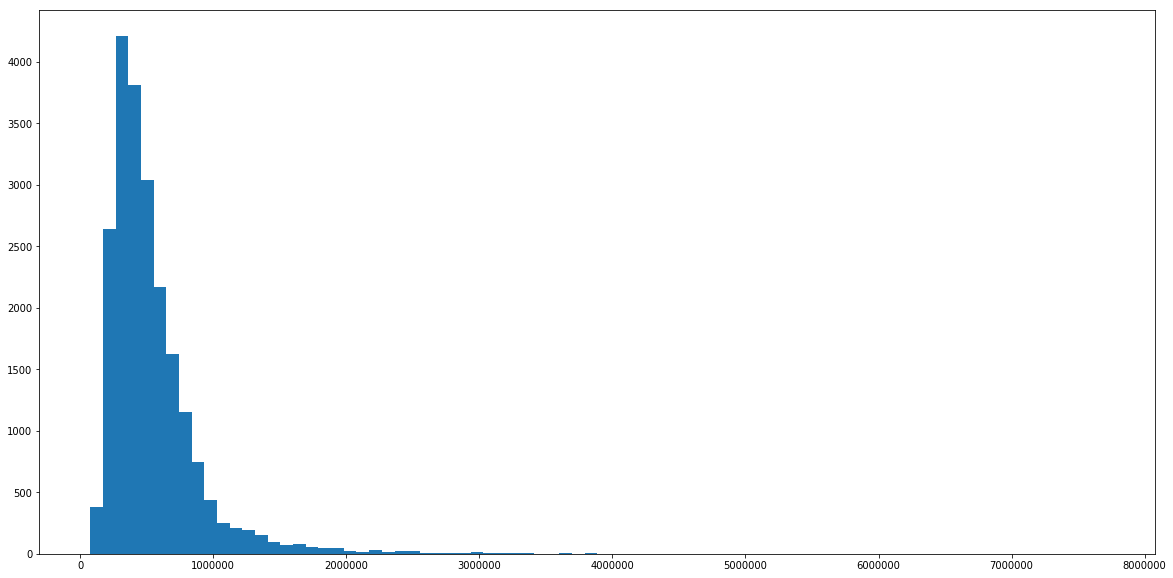

In [398]:
bins, counts = input_df.select('price').rdd.flatMap(lambda x: x).histogram(80)
plt.hist(bins[:-1], bins=bins, weights=counts)

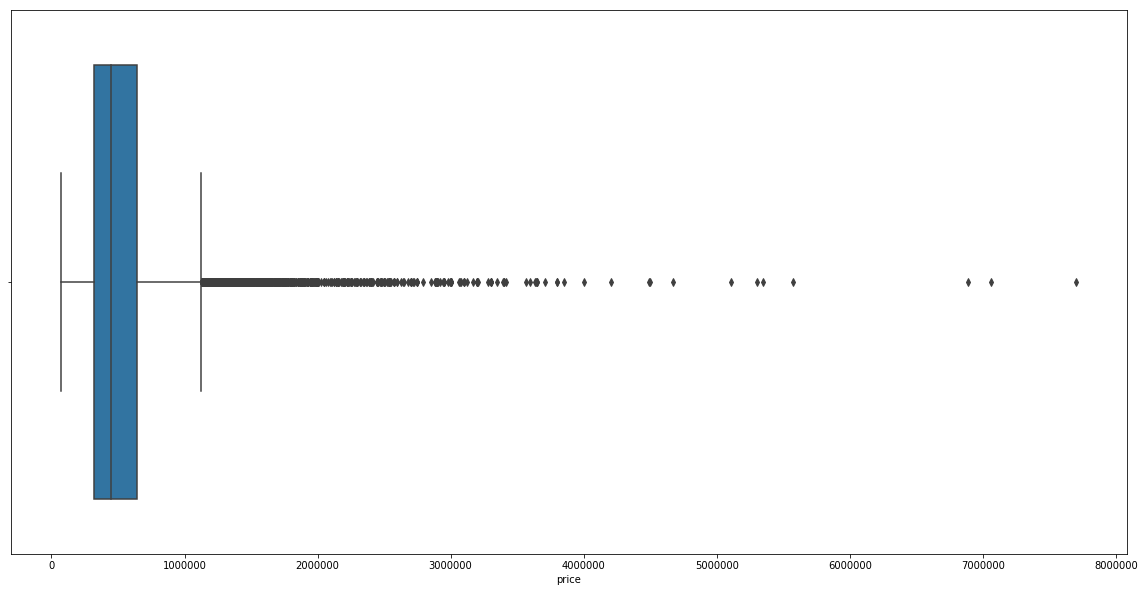

In [399]:
price_df = input_df.select(['price']).toPandas()
sns.boxplot(x= price_df['price'])

## 2nd Ques: Find out which variables are highly correlated with price.

In [ ]:
for i in input_df.columns:
    if i != "price" and i != "date":
        print("Corelation between ","price and ", i, input_df.stat.corr( 'price', i))

Corelation between  price and  id -0.016762196299423427
Corelation between  price and  bedrooms 0.30834959814563817
Corelation between  price and  bathrooms 0.5251375054139623
Corelation between  price and  sqft_living 0.7020350546118008
Corelation between  price and  sqft_lot 0.0896608605871001
Corelation between  price and  floors 0.25679388755071825
Corelation between  price and  waterfront 0.26636943403060087
Corelation between  price and  view 0.397293488294503
Corelation between  price and  condition 0.03636178912899724
Corelation between  price and  grade 0.6674342560202374
Corelation between  price and  sqft_above 0.605567298356079
Corelation between  price and  sqft_basement 0.3238160207119829
Corelation between  price and  yr_built 0.05401153149479274


## 3rd Ques: Find out which zip codes have the highest median house &#39;price&#39;. Do a bar plot to depict the top 10.

In [ ]:
fifty_percentile = F.expr('percentile_approx(zipcode, 0.5)')
# print(input_df.select(["zipcode", "price"]).groupBy("zipcode").count().orderBy("count", ascending=False).show(5))

output_df_3 = input_df.select(["zipcode", "price"]).groupBy("zipcode").agg(fifty_percentile.alias('med_val')).orderBy("med_val", ascending=False)
print(output_df_3.show(10))
zip_10_top = output_df_3.toPandas()[0:10]
zip_10_top
sns.barplot( data = zip_10_top,
          x='zipcode',
          y='med_val',
          order = zip_10_top.zipcode)


In [ ]:
fifty_percentile = F.expr('percentile_approx(zipcode, 0.5)')
# print(input_df.select(["zipcode", "price"]).groupBy("zipcode").count().orderBy("count", ascending=False).show(5))

output_df_3_1 = input_df.select(["zipcode", "price"]).groupBy("zipcode").mean().orderBy("avg(price)", ascending=False)
print(output_df_3_1.show(10))
zip_10_top_mean = output_df_3_1.toPandas()[0:10]
zip_10_top_mean
sns.barplot( data = zip_10_top_mean,
          x='zipcode',
          y='avg(price)',
          order = zip_10_top_mean.zipcode)


## 4th Ques.Find out if there are any missing values in the dataset and your strategy for imputing those.

In [ ]:

if(input_df.na.drop(how = 'any').count() == input_df.count()):
    print('No missing values as values after dropping na and before dropping na are the same')
    
for i in input_df.columns:
    print(i, input_df.filter(input_df[i].isNotNull()).count())


"""
    There are no missing values.
"""

In [ ]:
input_df.count()

## 5th Ques: Do some variables need feature engineering or transformation, if they need to be used to predict prices. Explain what transformations you will apply.

In [ ]:
input_df_backup = input_df

In [ ]:
for i in input_df.columns:
    if i != "price":
        temp_df = input_df.select([i, "price"]).groupBy(i).count().orderBy("count", ascending=False)
        print(i, temp_df.show(10), temp_df.count())

In [ ]:
input_df = input_df_backup

#####  Find the value of difference between current year and the year the house was built. Same for renovation

In [ ]:
input_df = input_df.withColumn("diffCurrentAndBuild", lit(2016) - input_df.yr_built)
input_df = input_df.withColumn("diffCurrentAndRenovated", lit(2016) - input_df.yr_renovated)


##### Log value of price is used to remove the outliers

In [ ]:
input_df = input_df.withColumn( 'log_price', log('price') )

In [ ]:
cont_values = ['sqft_living', 'bedrooms', 'bathrooms', 'floors','diffCurrentAndBuild', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'diffCurrentAndRenovated']

category_values = ['zipcode', 'waterfront','grade', 'condition','view']

In [ ]:
input_df.show()

In [ ]:
def one_hot_encode(df, col):
    indexer = StringIndexer().setInputCol(col).setOutputCol(col+"Index").fit(df)
    indexed = indexer.transform(df)

    encoder = OneHotEncoder(dropLast=True).setInputCol(col+"Index").setOutputCol(col+"Vec")

    encoded = encoder.transform(indexed)
    encoded.show()
    return encoded

In [ ]:
for col in category_values:
    input_df = one_hot_encode( input_df, col )


In [ ]:
input_df.select('viewVec').show(1)

In [ ]:
lis_vec_cols = []
for i in category_values:
    lis_vec_cols.append(i+"Vec")
lis_vec_cols

In [ ]:
all_cols = cont_values + lis_vec_cols

In [ ]:
input_df.columns

In [ ]:
all_cols

In [ ]:
input_df.select(all_cols)

In [ ]:
assembler = VectorAssembler( inputCols = all_cols, outputCol = "features")
output = assembler.transform(input_df)
output.show()

In [ ]:
output = output.withColumn( "label", round('log_price', 2) )

In [ ]:
train_df, test_df = output.randomSplit( [0.75, 0.25], seed = 42 )

In [ ]:
y_pred = lm.transform( test_df )
y_pred.select( 'features', 'label', 'prediction' ).show( 5 )

## 6 Ques.Build a regression model to predict the prices.

In [ ]:
def get_r2( model, test_df ):
    y_pred = model.transform( test_df )
    y_pred = y_pred.withColumn( "y_pred", exp( 'prediction' ) )

    r2_evaluator = RegressionEvaluator(labelCol="price",
                              predictionCol="y_pred",
                              metricName="r2" )

    return r2_evaluator.evaluate(y_pred)



In [ ]:
def get_rmse( model, test_df ):
    y_pred = model.transform( test_df )
    y_pred = y_pred.withColumn( "y_pred", exp( 'prediction' ) )
    rmse_evaluator = RegressionEvaluator(labelCol="price",
                              predictionCol="y_pred",
                              metricName="rmse" )

    return rmse_evaluator.evaluate(y_pred)


In [ ]:
all_models = []

In [ ]:
lg = LinearRegression(maxIter=500, regParam=0.0)
lgm = lg.fit(train_df)
print(lgm.intercept)
print(lgm.coefficients)
y_pred = y_pred.withColumn("y_pred", exp('prediction'))
print("rmse:",get_rmse(lgm, test_df))
print("R2", get_r2(lgm, test_df))
all_models.append({'model':"Linear Regression", "rmse": get_rmse(lgm, test_df), "R2":get_r2(lgm, test_df)})

## 7 Ques.Build the linear model with L1 and L2 regularization parameters. Do a Grid Search for to find optimal values for hyper parameters.

## Ridge

In [373]:
lrm = LinearRegression(maxIter=50)
paramGrid = ParamGridBuilder().addGrid(lrm.regParam, np.logspace(-1,-3, 3)).addGrid(lrm.elasticNetParam, [0.0]).build()
evaluator = RegressionEvaluator(
  metricName="r2",
  labelCol="label",
)

crossval = CrossValidator(estimator=lrModel,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=2)
cvModel = crossval.fit(train_df)

In [375]:
get_r2(cvModel.bestModel, test_df )
all_models.append({'model':"Ridge", "rmse": get_rmse(cvModel.bestModel, test_df), "R2":get_r2(cvModel.bestModel, test_df)})

## Lasso

In [376]:
lrm = LinearRegression(maxIter=50)
paramGrid = ParamGridBuilder().addGrid(lrm.regParam, np.logspace(-1,-3, 3)).addGrid(lrm.elasticNetParam, [1.0]).build()
evaluator = RegressionEvaluator(
  metricName="r2",
  labelCol="label",
)

crossval = CrossValidator(estimator=lrModel,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=2)
cvModel = crossval.fit(train_df)
get_r2(cvModel.bestModel, test_df )
all_models.append({'model':"Lasso", "rmse": get_rmse(cvModel.bestModel, test_df), "R2":get_r2(cvModel.bestModel, test_df)})

## Decision Tree

In [364]:
dtm = DecisionTreeRegressor(featuresCol="features",
                              labelCol="label",
                              maxDepth=13)
tlm = dtm.fit(train_df)
print(get_r2(tlm, test_df))
print(get_rmse(tlm, test_df))
all_models.append({'model':"Decision Tree", "rmse": get_rmse(tlm, test_df), "R2":get_r2(tlm, test_df)})

0.663796073061433
212383.57369376486


## RandomForest

In [365]:
rfm = RandomForestRegressor(featuresCol="features",
                              labelCol="label",
                              numTrees=100,
                              maxDepth=10,
                              featureSubsetStrategy='onethird')
rflm = rfm.fit(train_df)
print(get_r2(rflm, test_df))
print(get_rmse(rflm, test_df))
all_models.append({'model':"Random Forest", "rmse": get_rmse(rflm, test_df), "R2":get_r2(rflm, test_df)})

0.7354180406705659
188408.1336222905


In [381]:
comp_models = pd.DataFrame(all_models)

In [382]:
comp_models

,R2,model,rmse
0,0.840114,Linear Regression,146462.072018
1,0.663796,Decision Tree,212383.573694
2,0.735418,Random Forest,188408.133622
3,0.870527,Lasso,131797.976437
4,0.870527,Ridge,131797.976437
5,0.840114,Lasso,146462.072018


In [385]:
comp_models[comp_models.rmse == comp_models.rmse.min()]

,R2,model,rmse
3,0.870527,Lasso,131797.976437
4,0.870527,Ridge,131797.976437


In [386]:
comp_models[comp_models.R2 == comp_models.R2.max()]

,R2,model,rmse
3,0.870527,Lasso,131797.976437
4,0.870527,Ridge,131797.976437
